***Милютина Лилия Александровна***

In [1]:
import pandas as pd
import numpy as np
import scipy
import time

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

**Чтение и подготовка данных**

In [2]:
# Read data.
ratings = pd.read_csv("rs/ratings.csv")
ratings = ratings.iloc[:, :-1]
ratings.head()

,userId,movieId,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0


In [3]:
# Split for train and test sets.
trainset, testset = train_test_split(ratings, test_size=0.3)

In [4]:
# Convert to convinient form.
def convert_matrix(df, fillna=0):
    return df.pivot(
        index='userId',
        columns='movieId',
        values='rating'
    ).fillna(fillna)

In [5]:
trainset = convert_matrix(trainset).iloc[:100, :100]
testset = convert_matrix(testset).iloc[:100, :100]

for column in trainset.columns:
    if column not in testset.columns:
        testset[column] = 0
        
for column in testset.columns:
    if column not in trainset.columns:
        trainset[column] = 0

In [6]:
trainset.head()

movieId,1,2,3,4,5,6,7,8,9,10,...,83,106,117,119,121,122,125,126,132,135
userId,,,,,,,,,,,,,,,,,,,,,
1,4.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0


**Функция для вычисления ошибки RMSE**

In [7]:
# RMSE.
def rmse(y_1, y_2):
    return ((y_1.values - y_2.values) ** 2).mean() ** .5

**Создание класса для KNN**

In [8]:
# Class KNN.

def calculate_distance(y_1, y_2, metric):
    """
    Calculate metric:
    euclid or cosine.
    """
        
    if metric == 'cosine':
        val = np.dot(y_1, y_2) / np.linalg.norm(y_1) * np.linalg.norm(y_2)
    elif metric == 'euclid':
        val = np.linalg.norm(y_1 - y_2)
    else:
        print('Metric doesn\'t exist.')
    
    return val


class KNN:
    def __init__(self, k=2, user_based=True, metric='euclid'):
        self.k = k
        self.user_based = user_based
        self.metric = metric   # euclid and cosine
        self.trainset = None
        
    def fit(self, trainset):
        """
        Remember trainset
        and correct k
        (if > then shape).
        """
        self.trainset = trainset.copy(deep=True)
        if self.k > self.trainset.shape[0]:
            self.k = self.trainset.shape[0] - 1
        
    def predict(self, testset):
        """
        Find k-neigthbours.
        User-based and item-based are available.
        """
        preds = []
        if self.user_based:
            for i in range(testset.shape[0]):
                y = testset.iloc[i, :]
                res = np.zeros(self.trainset.shape[0])
                for j in range(self.trainset.shape[0]):
                    res[j] = calculate_distance(y.values, self.trainset.iloc[j, :], self.metric)

                neighbours_ind = np.argpartition(res, self.k)[:self.k]
                neighbours_mean = self.trainset.iloc[neighbours_ind, :].mean(axis=0)
                preds.append(neighbours_mean)
        else:
            preds = []
            for i in range(testset.shape[0]):
                pred = np.zeros(testset.shape[1])
                for j in range(testset.shape[1]):
                    el = testset.iloc[i, j]
                    if el != 0:
                        y = trainset.iloc[:, j]
                        res = np.zeros(self.trainset.shape[1])
                        for l in range(self.trainset.shape[1]):
                            res[l] = calculate_distance(y.values, self.trainset.iloc[:, l], self.metric)
                        res[res == 0] = np.inf

                        neighbours_ind = np.argpartition(res, self.k)[:self.k]
                        neighbours_mean = self.trainset.iloc[:, neighbours_ind].mean(axis=0).iloc[0]
                        pred[j] = neighbours_mean
                    else:
                        pred[j] = 0
                preds.append(pred)
                
        preds = pd.DataFrame(preds)
        return preds

**Создание класса для регрессии Надарайя-Ватсона**

In [9]:
class KNNWithMeans:
    def __init__(self, k=2, user_based=True, metric='euclid'):
        self.k = k
        self.user_based = user_based
        self.metric = metric
        self.trainset = None
        self.mu = None
        
    def fit(self, trainset):
        """
        Remember trainset
        and correct k
        (if > then shape).
        """
        self.trainset = trainset.copy(deep=True)
        
        if self.user_based:
            self.mu = pd.DataFrame(self.trainset.mean(axis=1))
        else:
            self.mu = pd.DataFrame(self.trainset.mean(axis=0)).T
            
        df = self.mu
        if self.user_based:
            df = df[np.repeat(df.columns.values, self.trainset.shape[1])]
            df.columns = self.trainset.columns
        else:
            df = pd.concat([df] * self.trainset.shape[0])
            df.columns = self.trainset.columns
            df.set_index(self.trainset.index)
        
        self.trainset = pd.DataFrame(trainset.values + df.values)
        
        if self.k > self.trainset.shape[0]:
            self.k = self.trainset.shape[0] - 1
            
    def predict(self, testset):
        """
        Find k-neigthbours.
        User-based and item-based are available.
        Take into account mean across axis users or items
        depends on method.
        """
        preds = []
        if self.user_based:
            for i in range(testset.shape[0]):
                y = testset.iloc[i, :]
                res = np.zeros(self.trainset.shape[0])
                for j in range(self.trainset.shape[0]):
                    res[j] = calculate_distance(y.values, self.trainset.iloc[j, :], self.metric)

                neighbours_ind = np.argpartition(res, self.k)[:self.k]
                neighbours_mean = self.trainset.iloc[neighbours_ind, :].mean(axis=0)
                preds.append(neighbours_mean)
        else:
            preds = []
            for i in range(testset.shape[0]):
                pred = np.zeros(testset.shape[1])
                for j in range(testset.shape[1]):
                    el = testset.iloc[i, j]
                    if el != 0:
                        y = trainset.iloc[:, j]
                        res = np.zeros(self.trainset.shape[1])
                        for l in range(self.trainset.shape[1]):
                            res[l] = calculate_distance(y.values, self.trainset.iloc[:, l], self.metric)
                        res[res == 0] = np.inf

                        neighbours_ind = np.argpartition(res, self.k)[:self.k]
                        neighbours_mean = self.trainset.iloc[:, neighbours_ind].mean(axis=0).iloc[0]
                        pred[j] = neighbours_mean
                    else:
                        pred[j] = 0
                preds.append(pred)
                
        preds = pd.DataFrame(preds)
        return preds

**Создание класса SVD с двумя методами оптимизации: SGD, ALS**

In [10]:
class SVD:
    def __init__(self, optimization_method='sgd', n_factors=10, n_epochs=10, lr_pq=1e-3, 
                 lr_bias=1e-6, biased=True, std_init=1e-1, reg_alpha=1e-2, verbose=True):
        
        if optimization_method not in ['sgd', 'als']:
            print('Incorrect name of optimization method')
            
        self.optimization_method = optimization_method
        self.n_factors = n_factors
        self.n_epochs = n_epochs
        self.lr_pq = lr_pq
        self.lr_bias = lr_bias
        self.biased = biased
        self.std_init = std_init
        self.reg_alpha = reg_alpha
        self.verbose = verbose
        
        self.trainset = None
        self.bu = {}
        self.bi = {}
        self.pu = {}
        self.qi = {}
        
    def fit(self, trainset):
        """
        Find pu, qi, mu, bu, bi: 
        r' = mu + bu + bi + pu * qi.
        SGD or ALS can be used for optimization.
        """
        self.trainset = trainset
            
        if self.optimization_method == 'sgd':
            self.sgd()
        else:
            
            df = self.trainset.replace(0, np.NaN)
            self.mu = df.mean(skipna=True, axis=1).mean(axis=0)
            self.biased = False
            
            X, y = self.als()
            X = X.toarray()
            y = y.toarray().T
            
            for u in range(self.trainset.shape[0]):
                u_id = int(self.trainset.index[u])
                for f in range(self.n_factors):
                    self.pu[u_id, f] = X[u, f]
                
            for i in range(self.trainset.shape[1]):
                i_id = int(self.trainset.columns[i])
                for f in range(self.n_factors):
                    self.qi[i_id, f] = y.T[i, f]
                
    def sgd(self):
        """
        Stochastic gradient descent.
        """
        
        if not self.biased:
            self.mu = 0
        else:
            df = self.trainset.replace(0, np.NaN)
            self.mu = df.mean(skipna=True, axis=1).mean(axis=0)
        
        bu = np.zeros(self.trainset.shape[0])
        bi = np.zeros(self.trainset.shape[1])
        pu = np.random.normal(self.mu, self.std_init, (self.trainset.shape[0], self.n_factors))
        qi = np.random.normal(self.mu, self.std_init, (self.trainset.shape[1], self.n_factors))

        for current_epoch in range(self.n_epochs):
            if self.verbose:
                print (f'Processing epoch {current_epoch+1} / {self.n_epochs}')
            for u in range(self.trainset.shape[0]):
                for i in range(self.trainset.shape[1]):
                    r = self.trainset.iloc[u, i]

                    dot = 0
                    for f in range(self.n_factors):
                        dot += qi[i, f] * pu[u, f]
                    err = r - self.mu - dot - bu[u] - bi[i]
                    
                    # update biases
                    if self.biased:
                        bu[u] += self.lr_bias * (err - self.reg_alpha *  bu[u])
                        bi[i] += self.lr_bias * (err - self.reg_alpha *  bi[i])

                    for f in range(self.n_factors):
                        pu[u, f] += self.lr_pq * (err * pu[u, f] - self.reg_alpha * qi[i, f]) 
                        qi[i, f] += self.lr_pq * (err * qi[i, f] - self.reg_alpha * pu[u, f])
      
        for u in range(self.trainset.shape[0]):
            u_id = int(self.trainset.index[u])
            self.bu[u_id] = bu[u]
            for f in range(self.n_factors):
                self.pu[u_id, f] = pu[u, f]
                
        for i in range(self.trainset.shape[1]):
            i_id = int(self.trainset.columns[i])
            self.bi[i_id] = bi[i]
            for f in range(self.n_factors):
                self.qi[i_id, f] = qi[i, f]
                
    def als(self):
        """
        Alternative least squares.
        """
        
        confidence = self.trainset
    
        X = scipy.sparse.csr_matrix(np.random.normal(0, size = (self.trainset.shape[0], self.n_factors)))
        Y = scipy.sparse.csr_matrix(np.random.normal(0, size = (self.trainset.shape[1], self.n_factors)))
        X_I = scipy.sparse.eye(self.trainset.shape[0])
        Y_I = scipy.sparse.eye(self.trainset.shape[1])
        I = scipy.sparse.eye(self.n_factors)
        lI = self.reg_alpha * I
        
        for i in range(self.n_epochs):
            
            if self.verbose:
                print (f'Processing epoch {i+1} / {self.n_epochs}')

            yTy = Y.T.dot(Y)
            xTx = X.T.dot(X)

            for u in range(self.trainset.shape[0]):
                
                u_row = confidence.iloc[u,:].values
                p_u = u_row.copy()
                p_u[p_u != 0] = 1.0

                CuI = scipy.sparse.diags(u_row)
                Cu = CuI + Y_I
                
                yT_CuI_y = Y.T.dot(CuI).dot(Y)
                yT_Cu_pu = Y.T.dot(Cu).dot(p_u.T)
                X[u] = scipy.sparse.linalg.spsolve(yTy + yT_CuI_y + lI, yT_Cu_pu)

    
            for i in range(self.trainset.shape[1]):

                i_row = confidence.iloc[:,i].T.values
                p_i = i_row.copy()
                p_i[p_i != 0] = 1.0


                CiI = scipy.sparse.diags(i_row)
                Ci = CiI + X_I

                xT_CiI_x = X.T.dot(CiI).dot(X)
                xT_Ci_pi = X.T.dot(Ci).dot(p_i.T)
                Y[i] = scipy.sparse.linalg.spsolve(xTx + xT_CiI_x + lI, xT_Ci_pi)

        return X, Y
        
    def predict(self, testset):
        """
        Get predicted rating matrix.
        """
        preds = []
        for u in range(testset.shape[0]):
            u_id = int(self.trainset.index[u])
            known_user = u_id in self.trainset.index
            
            pred = []
            for i in range(testset.shape[1]):
                i_id = int(self.trainset.columns[i])
                known_item = i_id in self.trainset.columns
                
                if testset.iloc[u, i] == 0:
                    pred.append(0)
                    continue
                    
                if self.biased:
                    est = self.mu

                    if known_user:
                        est += self.bu[u_id]

                    if known_item:
                        est += self.bi[i_id]

                    if known_user and known_item:
                        for f in range(self.n_factors):
                            est += self.qi[i_id, f] * self.pu[u_id, f]

                else:
                    est = 0
                    if known_user and known_item:
                        for f in range(self.n_factors):
                            est += self.qi[i_id, f] * self.pu[u_id, f]
                    else:
                        print('User and item are unknown.')
                pred.append(est)
            preds.append(pred)
        preds = pd.DataFrame(preds)
        return preds

**Создание класса для SVD++**

In [11]:
class SVDpp:
    def __init__(self, n_factors=10, n_epochs=10, lr_pq=1e-4, 
                 lr_bias=1e-8, std_init=1e-1, reg_alpha=1e-2, verbose=True):
        self.n_factors = n_factors
        self.n_epochs = n_epochs
        self.lr_pq = lr_pq
        self.lr_bias = lr_bias
        self.std_init = std_init
        self.reg_alpha = reg_alpha
        self.verbose = verbose
        
        self.trainset = None
        self.bu = {}
        self.bi = {}
        self.pu = {}
        self.qi = {}
        
    def fit(self, trainset):
        self.trainset = trainset
        
        # Get mean of matrix.
        df = self.trainset.replace(0, np.NaN)
        self.mu = df.mean(skipna=True, axis=1).mean(axis=0)
        
        bu = np.zeros(self.trainset.shape[0])
        bi = np.zeros(self.trainset.shape[1])
        pu = np.random.normal(self.mu, self.std_init, (self.trainset.shape[0], self.n_factors))
        qi = np.random.normal(self.mu, self.std_init, (self.trainset.shape[1], self.n_factors))
        
        self.yj = np.random.normal(self.mu, self.std_init, (self.trainset.shape[1], self.n_factors))

        for current_epoch in range(self.n_epochs):
            if self.verbose:
                print (f'Processing epoch {current_epoch+1} / {self.n_epochs}')
            for u in range(self.trainset.shape[0]):
                
                # Compute implicit feedback.
                Iu = np.nonzero(self.trainset.iloc[u, :].to_numpy())[0]
                sqrt_Iu = np.sqrt(len(Iu))
                u_impl_fdb = np.zeros(self.n_factors)
                for j in Iu:
                    for f in range(self.n_factors):
                        u_impl_fdb[f] += self.yj[j, f] / sqrt_Iu
                        
                for i in range(self.trainset.shape[1]):
                    r = self.trainset.iloc[u, i]

                    dot = 0
                    for f in range(self.n_factors):
                        dot += qi[i, f] * (pu[u, f] + u_impl_fdb[f])
                    err = r - self.mu - dot - bu[u] - bi[i]
                    
                    bu[u] += self.lr_bias * (err - self.reg_alpha * bu[u])
                    bi[i] += self.lr_bias * (err - self.reg_alpha * bi[i])

                    for f in range(self.n_factors):
                        pu[u, f] += self.lr_pq * (err * qi[i, f] - self.reg_alpha * pu[u, f])
                        qi[i, f] += self.lr_pq * err * (pu[u, f] + u_impl_fdb[f] - self.reg_alpha * qi[i, f])
                        
                        for j in Iu:
                            self.yj[j, f] += self.lr_pq * (err * qi[i, f] / sqrt_Iu - self.reg_alpha * self.yj[j, f])
      
        for u in range(self.trainset.shape[0]):
            u_id = int(self.trainset.index[u])
            self.bu[u_id] = bu[u]
            for f in range(self.n_factors):
                self.pu[u_id, f] = pu[u, f]
                
        for i in range(self.trainset.shape[1]):
            i_id = int(self.trainset.columns[i])
            self.bi[i_id] = bi[i]
            for f in range(self.n_factors):
                self.qi[i_id, f] = qi[i, f]
        
    def predict(self, testset):
        preds = []
        for u in range(testset.shape[0]):
            u_id = int(self.trainset.index[u])
            known_user = u_id in self.trainset.index
            
            pred = []
            for i in range(testset.shape[1]):
                i_id = int(self.trainset.columns[i])
                known_item = i_id in self.trainset.columns
                
                if testset.iloc[u, i] == 0:
                    pred.append(0)
                    continue
                    
                est = self.mu
                if known_user and known_item:
                    est += self.bu[u_id]
                    est += self.bi[i_id]
                    
                    # Add implicit feedback.
                    Iu = np.nonzero(self.trainset.iloc[u, :].to_numpy())[0]
                    sqrt_Iu = np.sqrt(len(Iu))
                    u_impl_fdb = np.zeros(self.n_factors)
                    for j in Iu:
                        for f in range(self.n_factors):
                            u_impl_fdb[f] = self.yj[j, f] / sqrt_Iu
            
                    for f in range(self.n_factors):
                        est += self.qi[i_id, f] * (self.pu[u_id, f] + u_impl_fdb[f])
                else:
                    print('User and item are unknown.')
                pred.append(est)
            preds.append(pred)
        preds = pd.DataFrame(preds)
        return preds

**Расчет времени работы и метрики для всех построенных алгоритмов**

In [12]:
# Fit and predict.

calc_time = []
errors = []

models = {
          'KNN_user_based': KNN(user_based=True), 
          'KNN_item_based': KNN(user_based=False), 
          'KNNMeans_user': KNNWithMeans(user_based=True), 
          'KNNMeans_item': KNNWithMeans(user_based=False), 
          'SVD_sgd': SVD('sgd', verbose=False), 
          'SVD_als': SVD('als', verbose=False), 
          'SVD++': SVDpp(verbose=False)}

for model_name in models:
    model = models[model_name]
    print(f'Calculating with model: {model_name}')
    start_time = time.time()
    model.fit(trainset)
    r_pred = model.predict(testset)
    err = rmse(r_pred, testset)
    c_time = time.time() - start_time
    calc_time.append(c_time)
    errors.append(err)
    print(f'Time of caltulation: {c_time}, RMSE: {err}')

Calculating with model: KNN_user_based
Time of caltulation: 2.7274184226989746, RMSE: 0.4312471438735555
Calculating with model: KNN_item_based
Time of caltulation: 3.758500337600708, RMSE: 0.49109813976728
Calculating with model: KNNMeans_user
Time of caltulation: 1.8198819160461426, RMSE: 0.43007132720238017
Calculating with model: KNNMeans_item
Time of caltulation: 3.6164281368255615, RMSE: 0.4296416273220367
Calculating with model: SVD_sgd
Time of caltulation: 7.265438556671143, RMSE: 0.13673037029817944
Calculating with model: SVD_als
Time of caltulation: 3.683363437652588, RMSE: 0.5017349248789563
Calculating with model: SVD++
Time of caltulation: 17.50696349143982, RMSE: 0.21950505553065425


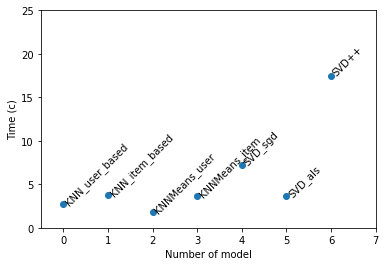

In [24]:
model_ids = list(range(len(models)))
plt.plot(model_ids, calc_time, 'o')
plt.xlabel('Number of model')
plt.ylabel('Time (c)')
plt.xlim([-0.5, 7])
plt.ylim([0, 25])
i = 0
for model_name in models.keys():
    plt.annotate(model_name, xy=(model_ids[i], calc_time[i]), rotation=45)
    i += 1
plt.show()

**Выводы:**    

Как видно из графика, алгоритмы SVD-sgd и SVD++ дольше решают задачу, нежели KNN.    
Особенно, SVD++, который учитывает также неявный отлик от пользователя, что является трудоемким.    
Алгоритмы группы KNN работают быстрее, так как в принципе не требуют никакого обучения, а просто находят ближайших соседей.   
При качественной векторизации, наверное, будут быстрее работать матричные разложения.

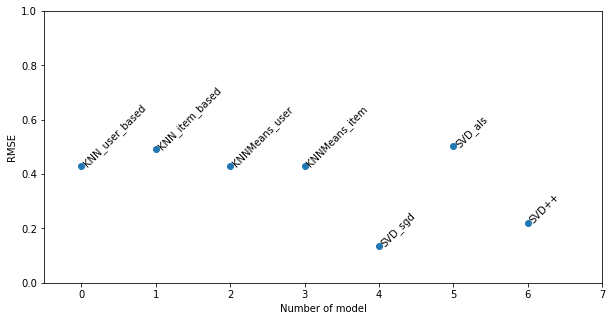

In [14]:
model_ids = list(range(len(models)))
plt.figure(figsize=(10,5))
plt.plot(model_ids, errors, 'o')
plt.xlabel('Number of model')
plt.ylabel('RMSE')
plt.xlim([-0.5, 7])
plt.ylim([0, 1])
i = 0
for model_name in models.keys():
    plt.annotate(model_name, xy=(model_ids[i], errors[i]), rotation=45)
    i += 1
plt.show()

**Выводы:**    

Матричные разложения SVD дают ожидаемо лучше результат, так обучают латентные представления юзеров и товаров, что продвинутее, нежели, чем просто среднее по соседям.

In [15]:
def calculate_knn_with_different_k(model, model_name, ks):
    calc_time = []
    errors = []
    print(f'Model: {model_name}')
    for k in ks:
        model = KNN(k=k, user_based=False)
        model_name_k = model_name + '_' + str(k)
        print(f'Number of neighbours: {k}')
        start_time = time.time()
        model.fit(trainset)
        r_pred = model.predict(testset)
        err = rmse(r_pred, testset)
        c_time = time.time() - start_time
        calc_time.append(c_time)
        errors.append(err)
        print(f'Time of caltulation: {c_time}, RMSE: {err}')
    return errors

Model: KNN_item_based
Number of neighbours: 1
Time of caltulation: 3.8053438663482666, RMSE: 0.49109813976728
Number of neighbours: 3
Time of caltulation: 4.176325559616089, RMSE: 0.4923395449052183
Number of neighbours: 5
Time of caltulation: 3.7216382026672363, RMSE: 0.4922041732840125
Number of neighbours: 7
Time of caltulation: 3.8947606086730957, RMSE: 0.4928493067755997
Number of neighbours: 20
Time of caltulation: 3.6301960945129395, RMSE: 0.495671993585703
Number of neighbours: 50
Time of caltulation: 3.7406978607177734, RMSE: 0.4949738458828993


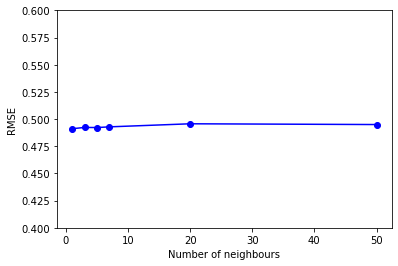

In [16]:
model_name = 'KNN_item_based'
model = KNN(user_based=False)
ks = [1, 3, 5, 7, 20, 50]
errors = calculate_knn_with_different_k(model, model_name, ks)
plt.plot(ks, errors, 'ro-', color='blue')
plt.ylim([0.4, 0.6])
plt.xlabel('Number of neighbours')
plt.ylabel('RMSE')
plt.show()

**Выводы:**  
В зависимости от количества соседей изменения качества существенного не происходит.   
Кажется, что существенный прирост будет на датасетах большего размера.

In [17]:
def calculate_svd_with_different_factors(model_name, factors):
    calc_time = []
    errors = []
    print(f'Model: {model_name}')
    for k in factors:
        model = SVD('sgd', k, verbose=False)
        model_name_k = model_name + '_' + str(k)
        print(f'Number of factors: {k}')
        start_time = time.time()
        model.fit(trainset)
        r_pred = model.predict(testset)
        err = rmse(r_pred, testset)
        c_time = time.time() - start_time
        calc_time.append(c_time)
        errors.append(err)
        print(f'Time of caltulation: {c_time}, RMSE: {err}')
    return errors

Model: KNN_item_based
Number of factors: 1
Time of caltulation: 4.200167655944824, RMSE: 0.13673833546151773
Number of factors: 3
Time of caltulation: 4.802179574966431, RMSE: 0.13673523301448953
Number of factors: 5
Time of caltulation: 5.60408091545105, RMSE: 0.13673284935319935
Number of factors: 7
Time of caltulation: 6.767555475234985, RMSE: 0.13673170886529962
Number of factors: 20
Time of caltulation: 11.910883903503418, RMSE: 0.13672819176444095
Number of factors: 50
Time of caltulation: 28.431403636932373, RMSE: 0.13672619852319656
Number of factors: 70
Time of caltulation: 35.48832941055298, RMSE: 0.136724523547838


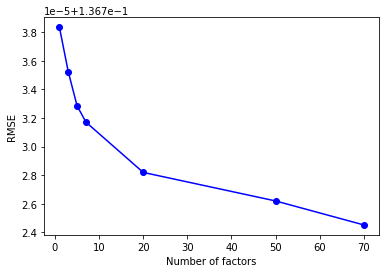

In [18]:
factors = [1, 3, 5, 7, 20, 50, 70]
errors = calculate_svd_with_different_factors(model_name, factors)
plt.plot(factors, errors, 'ro-', color='blue')
plt.xlabel('Number of factors')
plt.ylabel('RMSE')
plt.show()

**Выводы:**     
При увеличении количества факторов ошибка RMSE падает, так как мы учитываем больше скрытых латентных факторов.   

In [19]:
def calculate_svd_with_different_iterations(model_name, iterations):
    calc_time = []
    errors = []
    print(f'Model: {model_name}')
    for k in iterations:
        model = SVD('sgd', n_epochs=k, verbose=False)
        model_name_k = model_name + '_' + str(k)
        print(f'Number of iterations: {k}')
        start_time = time.time()
        model.fit(trainset)
        r_pred = model.predict(testset)
        err = rmse(r_pred, testset)
        c_time = time.time() - start_time
        calc_time.append(c_time)
        errors.append(err)
        print(f'Time of caltulation: {c_time}, RMSE: {err}')
    return errors

Model: SVD
Number of iterations: 1
Time of caltulation: 1.073857307434082, RMSE: 0.40422814928239753
Number of iterations: 3
Time of caltulation: 2.5512168407440186, RMSE: 0.1455936576109356
Number of iterations: 5
Time of caltulation: 4.906399726867676, RMSE: 0.13694091673499825
Number of iterations: 7
Time of caltulation: 5.39387845993042, RMSE: 0.1367005721003816
Number of iterations: 20
Time of caltulation: 14.723390579223633, RMSE: 0.13673809164107043
Number of iterations: 50
Time of caltulation: 34.756858587265015, RMSE: 0.13678483566091268


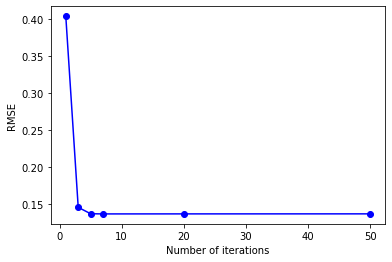

In [20]:
iterations = [1, 3, 5, 7, 20, 50]
model_name = 'SVD'
errors = calculate_svd_with_different_iterations(model_name, iterations)
plt.plot(iterations, errors, 'ro-', color='blue')
plt.xlabel('Number of iterations')
plt.ylabel('RMSE')
plt.show()

**Выводы:**     
Ожидаемо при увеличении количества итерация ошибка RMSE падает, так как мы точнее решаем поставленную оптимизационную задачу.

**Общие выводы:**   
- В ходе работы реализованы алгоритмы группы KNN и SVD. Очень интересно было посмотреть на них изнутри, а не использовать готовые библитечные реализации.
- Произведено сопоставление качества и времени работы алгоритмов. Получены результаты, не расходящиеся с теоретическими представлениями.